In [12]:
!pip install numpy scikit-learn matplotlib 

# tensorflow 

# autokeras ipykernel

In [13]:
!pip install ultralytics


In [14]:
%cd /workspaces/course-master-of-AI-


/workspaces/course-master-of-AI-


/root/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [15]:
# !mkdir ./dataset/mvtec_anomaly_detection
# !tar -xf ./dataset/mvtec_anomaly_detection.tar.xz -C ./dataset/mvtec_anomaly_detection

In [16]:
# Specify the directory path
directory_path = "/workspaces/course-master-of-AI-/dataset/mvtec_anomaly_detection/bottle"

# Get list of files and folders
files_and_folders = os.listdir(directory_path)

# Print the list
print(files_and_folders)

['ground_truth', 'license.txt', 'readme.txt', 'test', 'train']


In [20]:
import cv2
import numpy as np

In [21]:
def convert_to_yolo_bbox(bbox, image_width=None, image_height=None):
  """
  Converts a bounding box in top-left corner (x_min, y_min), width, height format to YOLO format.

  Args:
    bbox: A dictionary with keys "x_min", "y_min", "width", and "height".
    image_width: Optional, image width if using normalized coordinates.
    image_height: Optional, image height if using normalized coordinates.

  Returns:
    A list containing the center coordinates (x_center, y_center) and width and height of the bounding box in YOLO format.
  """
  x_min = bbox[0]
  y_min = bbox[1]
  width = bbox[2]
  height = bbox[3]

  # Calculate normalized center coordinates
  x_center_norm = (x_min + width / 2) / image_width
  y_center_norm = (y_min + height / 2) / image_height

  # Clip coordinates to [0, 1] range (safer approach)
  x_center_norm = clip_to_range(x_center_norm, 0, 1)
  y_center_norm = clip_to_range(y_center_norm, 0, 1)

  # Calculate normalized width and height
  width_norm = width / image_width
  height_norm = height / image_height

  return [x_center_norm, y_center_norm, width_norm, height_norm]

def clip_to_range(value, min_value, max_value):
  """Clips a value to be within a specified range."""
  return min(max(value, min_value), max_value)

In [22]:
def mask_to_bbox(mask_path):
    # Load the image
    mask = cv2.imread(mask_path)

    # height, width = mask.shape[:2]
    
    # Preprocess the image (adjust based on marker type)
    gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)[1]

    # Find contours
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    # Assuming a single dominant contour (adjust for multiple markers)
    cnt = cnts[0]

    # Get bounding box coordinates
    x, y, w, h = cv2.boundingRect(cnt)
    bbox = [x,y,w,h]
    return bbox # convert_to_yolo_bbox(bbox=bbox)


In [23]:
from PIL import Image
import shutil

def copy_image(source_path, destination_path):
    """Copies an image file with error handling."""
    if not os.path.exists(source_path):
        print(f"Error: Source file not found: {source_path}")
        return

    # Create destination directory if it doesn't exist
    directory = os.path.dirname(destination_path)

    # Create the directory structure if it doesn't exist
    os.makedirs(directory, exist_ok=True)
    
    try:
        shutil.copy2(source_path, destination_path)
        print(f"Copied image: {source_path} -> {destination_path}")
    except PermissionError as e:
        print(f"Error copying image: {e}")

    
def write_to_file(content, destination_path):

    # Extract directory path from the full path
    directory = os.path.dirname(destination_path)

    # Create the directory structure if it doesn't exist
    os.makedirs(directory, exist_ok=True) 
    
    with open(destination_path, "w") as file:
        # Write text to the file
        file.write(content)
        print(f"Successfully wrote \"{content}\" to: {destination_path}")



In [24]:
import random
def convert_to_YOLO_dataset(path_to_images="./dataset/mvtec_anomaly_detection/bottle", 
                            output_path='./dataset/yolo', train_ratio=.6, val_ratio=.3):
    
    path_ground_truths = os.path.join(path_to_images, 'ground_truth')
    path_images = os.path.join(path_to_images, 'test')

    classes =  os.listdir(path_ground_truths)

    # print(classes)

    class_objs = [(c, image, image.replace('.','_mask.')) for c in classes for image in os.listdir(os.path.join(path_images, c))]
    # print(class_objs)
    
    random.shuffle(class_objs)

    train_size = int(len(class_objs) * train_ratio)
    val_size = int(len(class_objs) * val_ratio)

    train_objs = class_objs[:train_size]
    val_objs = class_objs[train_size:train_size + val_size]
    test_objs = class_objs[train_size + val_size:]
    
    temp = "".join([ f"\n  {i}: {item}" for i, item in enumerate(classes)])
    
    data = f"path: {output_path}\ntrain: images/train\nval: images/val\ntest: images/test\n\nnames:{temp}\n"
    
    write_to_file(data, f"{output_path}/data.yaml")
    
    create_label_and_file(output_path, path_ground_truths, path_images, classes, train_objs, 'train')
    create_label_and_file(output_path, path_ground_truths, path_images, classes, val_objs, 'val')
    create_label_and_file(output_path, path_ground_truths, path_images, classes, test_objs, 'test')

def create_label_and_file(output_path, path_ground_truths, path_images, classes, class_objs, folder_name):
    for o in class_objs:
        source_path = os.path.join(path_images, o[0], o[1])
        target_path = os.path.join(output_path, 'images', folder_name, f'{o[0]}_{o[1]}')
        
        mask_source_path = os.path.join(path_ground_truths, o[0], o[2])
        label_target_path = os.path.join(output_path, 'labels', folder_name, f'{o[0]}_{o[1]}'.replace('.png','.txt'))
        
        copy_image(source_path, target_path)
        
        # Load the image
        mask = cv2.imread(mask_source_path)
        height, width = mask.shape[:2]
        bbox = convert_to_yolo_bbox(mask_to_bbox(mask_source_path), width, height)
        content = f"{classes.index(o[0])} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}"
        
        write_to_file(content, label_target_path)


In [25]:
convert_to_YOLO_dataset('/workspaces/course-master-of-AI-/dataset/mvtec_anomaly_detection/bottle', '/workspaces/course-master-of-AI-/dataset/yolo')

Successfully wrote "path: /workspaces/course-master-of-AI-/dataset/yolo
train: images/train
val: images/val
test: images/test

names:
  0: broken_large
  1: broken_small
  2: contamination
" to: /workspaces/course-master-of-AI-/dataset/yolo/data.yaml
Copied image: /workspaces/course-master-of-AI-/dataset/mvtec_anomaly_detection/bottle/test/contamination/004.png -> /workspaces/course-master-of-AI-/dataset/yolo/images/train/contamination_004.png
Successfully wrote "2 0.3377777777777778 0.6844444444444444 0.2288888888888889 0.23555555555555555" to: /workspaces/course-master-of-AI-/dataset/yolo/labels/train/contamination_004.txt
Copied image: /workspaces/course-master-of-AI-/dataset/mvtec_anomaly_detection/bottle/test/broken_large/000.png -> /workspaces/course-master-of-AI-/dataset/yolo/images/train/broken_large_000.png
Successfully wrote "0 0.6227777777777778 0.6133333333333333 0.4677777777777778 0.5955555555555555" to: /workspaces/course-master-of-AI-/dataset/yolo/labels/train/broken_lar

In [ ]:
def read_file(file_path):
  data = ""
  with open(file_path, "r") as f:
      data = f.read()

  return data

/workspaces/course-master-of-AI-
900 900
center_x: 0.22722222222222221, center_y: 0.43944444444444447, width: 0.14333333333333334, height: 0.25666666666666665
xmin: 140, ymin: 280, xmax: 269, ymax: 511


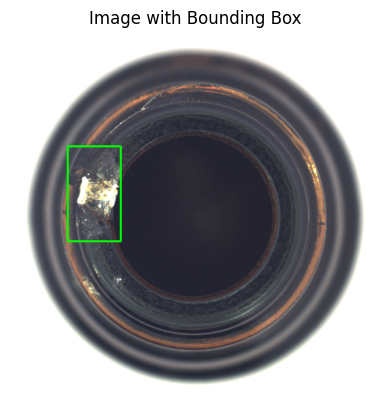

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

%cd /workspaces/course-master-of-AI-
image_path="./dataset/yolo/images/test/broken_small_017.png"
label_path="./dataset/yolo/labels/test/broken_small_017.txt"
# Sample image (replace this with your actual image data)
image = cv2.imread(image_path) # Random image data (width, height, channels)

# Parse the YOLO label
label_str = read_file(label_path)
class_id, center_x, center_y, width, height = map(float, label_str.split())

# Convert YOLO format (center, width, height) to normalized bbox (xmin, ymin, xmax, ymax)
image_height  = image.shape[0]
image_width = image.shape[1]

xmin = int((center_x - width / 2) * image_width)
ymin = int((center_y - height / 2) * image_height)
xmax = int((center_x + width / 2) * image_width)
ymax = int((center_y + height / 2) * image_height)

print(f"{image_height} {image_width}")
print(f"center_x: {center_x}, center_y: {center_y}, width: {width}, height: {height}")
print(f"xmin: {xmin}, ymin: {ymin}, xmax: {xmax}, ymax: {ymax}")

# Create the figure and plot the image
fig, ax = plt.subplots()
ax.imshow(image)

cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)  # Green bounding box with thickness 2

# Convert OpenCV image format to RGB for Matplotlib
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image with Matplotlib
plt.imshow(rgb_image)
plt.axis('off')  # Hide Matplotlib's default x and y axes
plt.title("Image with Bounding Box")
plt.show()